In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import t
from scipy import stats
from tqdm import tqdm

In [30]:
df = pd.read_csv("../demo/trajectories.txt")
X = df["tz"].values

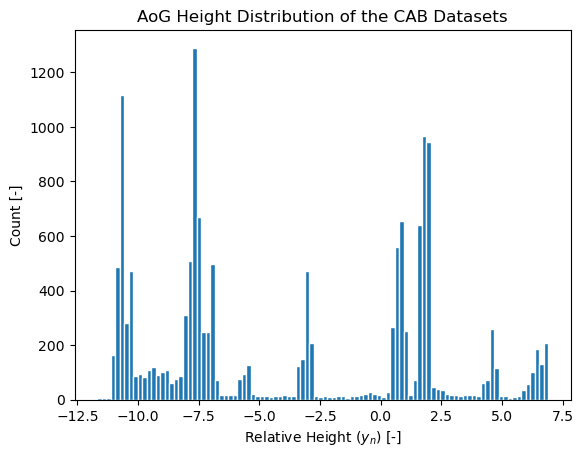

In [31]:
_ = plt.hist(X, bins=100, edgecolor='white')
_ = plt.ylabel(r"Count [-]")
_ = plt.xlabel(r"Relative Height ($y_n$) [-]")
_ = plt.title("AoG Height Distribution of the CAB Datasets")

### Gaussian Mixture Model without Latent Height, $\mathbf H$

In [85]:
"""
Functions
 - countnk = Yields K-dimensional vector containing cluster count
 - pzkz = Computes the first term of the full-conditional
 - pxxzz = Computes the second term of the full-conditional, the posterior predictive
"""

def countnk(Z, K): 
    Nk = np.zeros((K,))
    unique, count = np.unique(Z, return_counts=True)
    Nk[unique] += count
    return Nk

def pzkz(Z, K, N, n, alpha): 
    Nk = countnk(Z, K)
    Nk[Z[n]] -= 1
    denom = N - 1 + alpha
    return (Nk + alpha / K) / denom

def pxxzz(Z, K, X, n, mu0, var, alpha, beta): 
    Xn = X[n]
    Nk = countnk(Z, K)
    Nk[Z[n]] -= 1
    P = np.zeros((K,))
    
    for i in range(K): 
        Di = X[Z == i]
        Ni = Nk[i]
        mean = np.mean(Di)
        mui = (Ni * mean + var * mu0) / (var + Ni)
        vari = var + Ni
        alphai = alpha + Ni / 2
        betai = beta + 0.5 * np.sum(np.square(Di - mean))
        betai += 0.5 * (Ni * var * np.square(mean - mu0)) / (var + Ni)
        P[i] = t.pdf(Xn, 2 * alphai, mui, np.sqrt(betai * (vari + 1) / vari / alphai))
        
    return P

100%|████████████████████████████████████████████████████████| 45197/45197 [01:19<00:00, 571.67it/s]


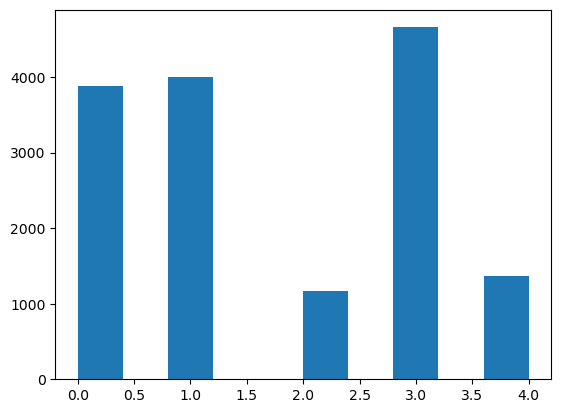

In [121]:
"""
Variables
 - K = Number of Clusters
 - N = Number of Samples, or Data Points
 - Z = N-dimensional Vector of Class Assignment, Zn for Xn
 - n = Current Sampling Index, within range [0, N)
 - alpha = Hyper-parameters for the Mixtures
 - alpha0 = Hyper-parameters for Cluster's Precision
 - beta0 = Hyper-parameters for Cluster's Precision
 - mu0 = Hyper-parameters for Cluster's Mean
 - var = Hyper-parameters for Cluster's Mean
"""

K = 5
alpha = 1
alpha0 = 2
beta0 = 1
mu0 = 0
var = 20
seed = 122
floor = [-12, -3.5, 0.5, 5]
floor = np.linspace(np.min(X), np.max(X), K + 1, endpoint=True)
    

def dpmm(S, X, K, alpha, alpha0, beta0, mu0, var, seed = None): 
    if seed != None: 
        np.random.seed(seed)
    
    n = 0
    N = X.size
    H = np.zeros((S, N), dtype=int)
    
    temp = np.linspace(np.min(X), np.max(X), K, endpoint=False)
    for i, fl in enumerate(temp): 
        HI = H[0]
        HI[X > fl] = i
        
    plt.hist(H[0])
        
    for s in tqdm(range(1, S), ncols=100): 
        Z = H[s - 1]
        p = pzkz(Z, K, N, n, alpha) * pxxzz(Z, K, X, n, mu0, var, alpha0, beta0)
        z = np.random.choice(np.arange(K), p=p/np.sum(p))
        H[s] = Z
        H[s, n] = z
        n = (n + 1) % N
        
    return K, H
    
K, Z = dpmm(X.size * 3, X, 5, alpha, alpha0, beta0, mu0, var, seed)

# 0 floor -8.630901152248526
# 1 floor -3.000733270949544
# 2 floor 1.382572503443943
# 3 floor 5.491966255043055


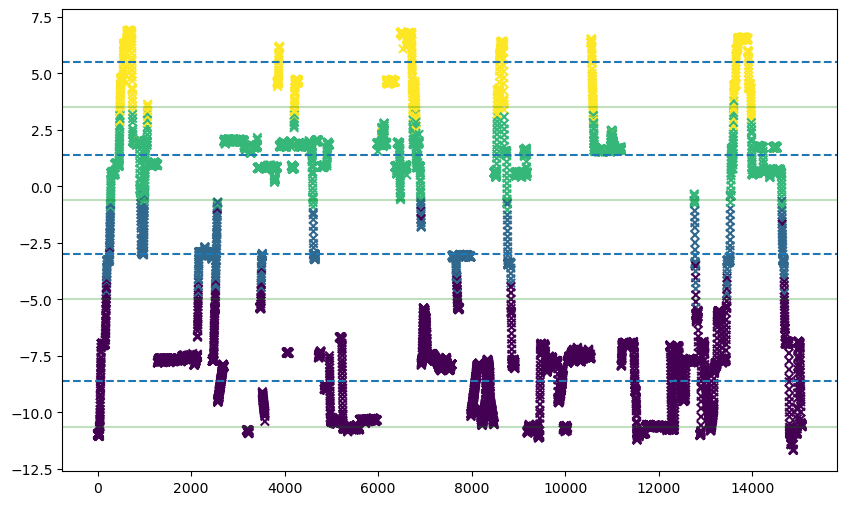

In [103]:
Xt = X
N = Xt.size
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(np.arange(N), Xt, marker="x", c=Z[-1])
Zi = Z[-1]

for k in range(K): 
    center = np.mean(Xt[Zi == k])
    print("#", k, "floor", center)
    ax.axhline(center, linestyle='--')
    ax.axhline(center - 2, linestyle="-", color='green', alpha=0.25)
    
# for fl in floor: 
#     ax.axhline(fl, linestyle="-.", alpha=0.1)

# 0 floor -10.095099523447658
# 1 floor -7.423220847924663
# 2 floor -3.0220005494664304
# 3 floor 1.3893562747230916
# 4 floor 5.4848446042341035
[-12.046000541075784, -8.9141727026158, -4.421262364977039, 0.17529695977176618, 3.2043878179501513]


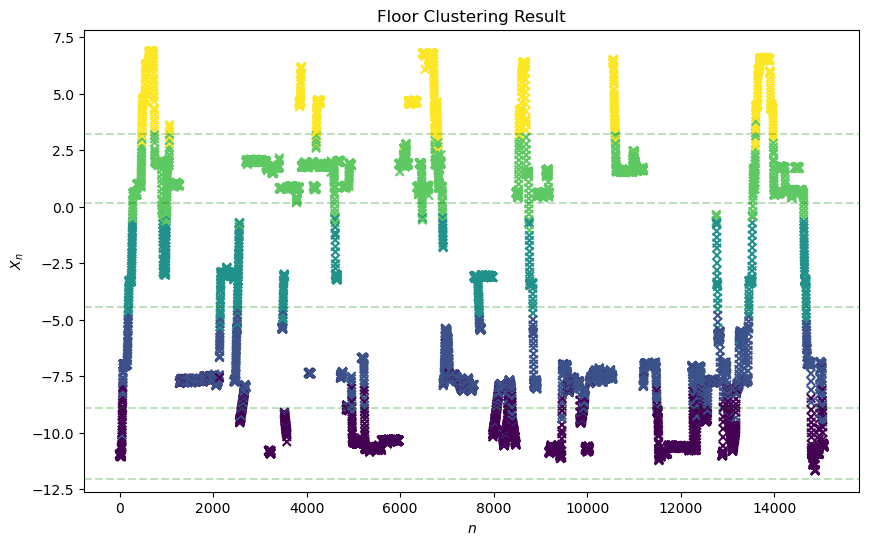

In [136]:
Xt = X
N = Xt.size
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(np.arange(N), Xt, marker="x", c=Z[-1])
Zi = Z[-1]

plt.xlabel(r"$n$")
plt.ylabel(r"$X_n$")
plt.title(r"Floor Clustering Result")

temp = []

for k in range(K): 
    center = np.mean(Xt[Zi == k])
    std = np.std(Xt[Zi == k])
    ax.axhline(center - 2 * std, linestyle="--", color='green', alpha=0.25)
    temp.append(center - 2 * std)
    print("#", k, "floor", center)

print(temp)
    

# 0 floor -3.4154626345936276
# 1 floor -4.016804203522477
# 2 floor -3.49787237032191
# 3 floor -4.020920457354353
# 4 floor -4.014120915023649


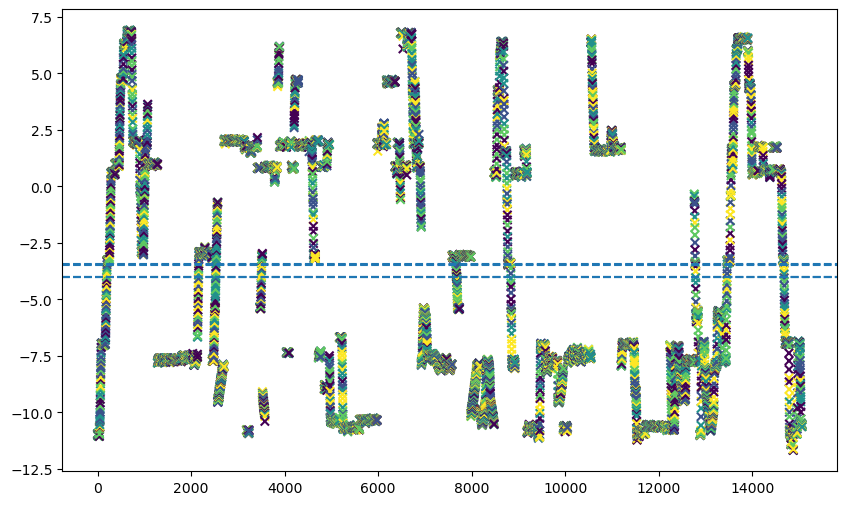